In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Optional
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from time import time

## Data Loading and Preparation

We first load price data OHLCV and clean it.

In [2]:
df = pd.read_pickle('../data/binance_1D_crypto_data.pkl')
df = df[df['open_time'].dt.date != df['open_time'].dt.date.max()]
df = df.drop_duplicates(keep='first')
df.head()

,open_time,open,high,low,close,volume,symbol
0,2024-06-17,0.09500000,0.29500000,0.09500000,0.21300000,1558854668.40000000,ZKUSDT
1,2024-06-18,0.21300000,0.23200000,0.18600000,0.22020000,1189119720.30000000,ZKUSDT
2,2024-06-19,0.22020000,0.24000000,0.21260000,0.22420000,727374424.10000000,ZKUSDT
3,2024-06-20,0.22420000,0.22420000,0.19100000,0.19830000,493478200.90000000,ZKUSDT
4,2024-06-21,0.19830000,0.20360000,0.17600000,0.18220000,382766488.90000000,ZKUSDT


High, Low, Close Prices are used to detect a breakout, volume is also used to confirm a trend. All assets/columns that have more than 10% null values are removed

In [3]:
def pivot_reindexed_data(df, value):
    new_df = df.pivot(values = value, columns = 'symbol', index = 'open_time')
    new_df = pd.DataFrame(new_df).astype(float)
    new_df = new_df.reindex(pd.date_range(new_df.index[0],new_df.index[-1],freq='1d'))
    return new_df

px_close = pivot_reindexed_data(df,'close').loc[:'2025-08']
# Omitting tickers with less than 90% of non null values.
px_close = px_close.loc[:,(px_close.notna().sum()/(px_close.shape[0]))>= 0.9]

px_high = pivot_reindexed_data(df,'high')[px_close.columns].loc[:'2025-08']
px_low = pivot_reindexed_data(df,'low')[px_close.columns].loc[:'2025-08']
vols = pivot_reindexed_data(df,'volume')[px_close.columns].loc[:'2025-08']


# Define date ranges
insample_start = pd.Timestamp("2021-06-01")
insample_end = pd.Timestamp("2023-12-31")
outsample_start = pd.Timestamp("2024-01-01")

px_close_train = px_close.loc[:insample_end]
px_high_train = px_high.loc[:insample_end]
px_low_train = px_low.loc[:insample_end]
vols_train = vols.loc[:insample_end]

In [4]:
px_close.head()

symbol,1INCHUSDT,AAVEUSDT,ADAUSDT,ALGOUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,AXSUSDT,BCHUSDT,BNBUSDT,...,TRXUSDT,TUSDUSDT,TWTUSDT,UNIUSDT,USDCUSDT,VETUSDT,XLMUSDT,XRPUSDT,XTZUSDT,ZECUSDT
2021-01-01,1.1550,90.711,0.17509,0.3978,NaN,5.861,3.6497,0.59310,341.83,37.7762,...,0.02685,0.9974,NaN,4.7353,0.9974,0.019052,0.13207,0.23746,2.0075,56.60
2021-01-02,1.0250,85.768,0.17742,0.4075,NaN,5.420,3.4956,0.54275,354.55,38.2331,...,0.02721,0.9989,NaN,4.8564,0.9989,0.019993,0.12751,0.22064,1.9992,57.46
2021-01-03,1.1080,93.778,0.20615,0.4253,NaN,5.829,3.4691,0.56523,423.61,41.2575,...,0.02949,0.9986,NaN,5.5155,0.9992,0.026226,0.13653,0.22540,2.1345,59.35
2021-01-04,1.0317,114.271,0.22528,0.4463,NaN,6.044,3.5999,0.56082,405.49,41.1333,...,0.03095,0.9994,NaN,5.4238,0.9994,0.024598,0.16404,0.23565,2.3284,60.34
2021-01-05,1.2501,119.689,0.25873,0.4794,NaN,6.196,4.2501,0.55605,418.09,41.8219,...,0.02852,0.9970,NaN,6.2518,0.9969,0.027964,0.19291,0.22573,2.3770,59.64


In [5]:
def drawdown(returns):
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative / rolling_max - 1)
    return drawdown

In [6]:
def duration(returns):
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative / rolling_max - 1)
    duration = (drawdown != 0).astype(int)
    if isinstance(returns, pd.DataFrame):
        ddd = pd.DataFrame(index = returns.index, columns = returns.columns)
        for col in returns.columns:
            ddd[col] = duration[col].groupby((duration[col] != duration[col].shift()).cumsum()).cumsum()
    else:
        ddd = duration.groupby((duration != duration.shift()).cumsum()).cumsum()
    return ddd

In [7]:
def calculate_metrics(returns, benchmark:Optional = False):
    """
    Compute total return, annualized return/vol, Sharpe, max drawdown, win rate.
    """
    
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative / rolling_max - 1)
    duration = (drawdown != 0).astype(int)
    max_duration = duration.groupby((duration != duration.shift()).cumsum()).cumsum().max()

    cum_ret = cumulative.iloc[-1] - 1
    ann_vol = returns.std() * np.sqrt(365)
    ann_ret = returns.mean() * 365
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    max_dd = drawdown.min()

    # consider only non-zero returns as individual trades
    trade_rets = returns[returns != 0]
    win_rate   = (trade_rets > 0).sum() / len(trade_rets)
    
    
    metrics = pd.Series({
        "Cumulative Return": f"{(cum_ret * 100):.2f}%",
        "Annualized Return": f"{(ann_ret * 100):.2f}%",
        "Annualized Volatility": f"{(ann_vol * 100):.2f}%",
        "Sharpe Ratio": sharpe,
        "Max Drawdown": f"{(max_dd * 100):.2f}%",
        "Max Drawdown Duration": f"{(max_duration):.2f} days",
        "Win Rate": f"{(win_rate * 100):.2f}%"
    })
    
    if benchmark:
        bench_rets = px_close['BTCUSDT'].ffill().pct_change().loc[returns.index]
        X = sm.add_constant(bench_rets)
        y = returns
        model = sm.OLS(y, X).fit()
        alpha = model.params['const']
        beta  = model.params['BTCUSDT']
        active_rets = returns - beta * bench_rets
        IR = active_rets.mean() / active_rets.std() * np.sqrt(365)
    
        metrics["Info Ratio"] = IR
        
    else: metrics["Info Ratio"] = "N/A"

    return metrics

In [8]:
def backtest_with_costs(prices, port, tcost_bps = 20):
    ret = prices.ffill().pct_change()
    gross_ret = (port.shift() * ret).sum(axis=1)

    # Turnover
    turnover = (port.fillna(0) - port.shift().fillna(0)).abs().sum(axis=1)

    # Cost in return units
    cost = turnover * (tcost_bps * 1e-4)
    net_ret = gross_ret - cost

    return net_ret, gross_ret, turnover

In [9]:
def top_pairs_corr_coint(prices, window=90, corr_threshold=0.83, pvalue_threshold=0.1, max_pairs=40):    
    logp = np.log(prices.ffill())
    log_rets = logp.diff()
    reb_dates = log_rets.index[window::window]

    schedule = []

    for date in reb_dates:
        block_idx = log_rets.index.get_loc(date)
        if date - pd.Timedelta(days = 182) > pd.Timestamp('2021-01-01'):
            block = log_rets.iloc[block_idx+1-182:block_idx+1]
        else:
            block = log_rets.iloc[:block_idx+1]
        corr_mat = block.corr(min_periods = 30)

        # 1) find correlated candidates
        candidates = []
        cols = corr_mat.columns
        for i, a in enumerate(cols):
            for b in cols[i+1:]:
                ρ = corr_mat.at[a,b]
                if pd.isna(ρ) or abs(ρ) < corr_threshold:
                    continue
                if abs(ρ) > 0.93:
                    continue

                # 2) test cointegration on log-prices over the SAME block
                y = logp[a].loc[block.index]
                x = logp[b].loc[block.index]
                
                if y.isna().any() == True or x.isna().any() == True:
                    n,m = y.isna().sum(), x.isna().sum()
                    if n > m:
                        y, x = y[n:], x[n:]
                    else:
                        y, x = y[m:], x[m:]
                score, pval, _ = coint(y, x)
                if pval < pvalue_threshold:
                    candidates.append((a, b, ρ, pval)) 
                    
        # 3) sort by |corr| (or p-value) and limit
        candidates.sort(key=lambda tup: abs(tup[2]), reverse=True)
        top = candidates[:max_pairs]
        pairs = [(a,b) for a,b,_,_ in top]
        schedule.append((date, pairs, len(pairs)))

    return pd.DataFrame(schedule, columns=['reb_date','trading_pairs', 'pairs_count'])

In [10]:
def compute_signals(log_rets, pairs, window = 90, start = px_close.index[0]):
    """
    Given returns `log_rets` and a list of pairs, compute three DataFrames:
      - beta[(x,y)]_t
      - spread[(x,y)]_t = log_rets_y - beta_t * log_rets_x
      - zscore[(x,y)]_t = (spread - mean)/std over rolling window
    All indexed by log_rets.index.
    """
    betas, spreads, zscores, vol_ind = {}, {}, {}, {}
    for x,y in pairs:
        vol_x = log_rets[x].rolling(window).std()
        vol_y = log_rets[y].rolling(window).std()
        corr  = log_rets[x].rolling(window).corr(log_rets[y])
        β     = corr * vol_y / vol_x
        s     = log_rets[y] - β * log_rets[x]
        m     = s.rolling(window, min_periods = 1).mean()
        sd    = s.rolling(window, min_periods = 1).std()
        z     = (s - m) / sd

        betas[(x,y)]  = β
        spreads[(x,y)] = s
        zscores[(x,y)] = z
        vol_ind[(x,y)] = sd / s.rolling(180, min_periods = 1).std()

    beta_df   = pd.DataFrame(betas).loc[start:]
    spread_df = pd.DataFrame(spreads).loc[start:]
    z_df      = pd.DataFrame(zscores).loc[start:]
    vol_ind   = pd.DataFrame(vol_ind).loc[start:]
    return beta_df, spread_df, z_df, vol_ind

In [11]:
def generate_portfolio(zscores, beta, factor, entry = 1.0, exit_z = 0.5):
    """
    Build a portfolio DataFrame indexed by zscores.index, columns=assets,
    where for each pair (x,y):
      - if z > entry_z:  pos[y] = -1, pos[x] = +beta
      - if z < -entry_z: pos[y] = +1, pos[x] = -beta
      - if |z| < exit_z: pos[y], pos[x] = 0
    Positions from overlapping pairs are summed.
    """
    # initialize flat portfolio
    assets = sorted({asset for pair in zscores.columns for asset in pair})
    portfolio = pd.DataFrame(index=zscores.index, columns=assets)

    # loop over each pair (columns in zscores are MultiIndex or tuples)
    for (x, y) in zscores.columns:
        z = zscores[(x, y)]
        β = beta[(x, y)]
        c = factor[(x, y)]
        entry_z = 1/(1+np.exp(-entry * c)) + 1

        # long spread when z < -entry_z
        long_mask  = z < -entry_z
        portfolio.loc[long_mask,  y] +=  1.0
        portfolio.loc[long_mask,  x] += -β.loc[long_mask]

        # short spread when z > entry_z
        short_mask = z >  entry_z
        portfolio.loc[short_mask, y] += -1.0
        portfolio.loc[short_mask, x] +=  β.loc[short_mask]

        # exit when |z| < exit_z: zero out those dates
        exit_mask = z.abs() < exit_z
        portfolio.loc[exit_mask, [x, y]] = 0.0
    portfolio = portfolio.ffill()

    return portfolio

In [12]:
def channel_bounds(high, low, le_lookback, se_lookback):
    """
    Highest high / lowest low over last 'lookback' bars, inclusive.
    """
    higher = high.rolling(le_lookback, min_periods=le_lookback).max()
    lower = low.rolling(se_lookback, min_periods=se_lookback).min()
    return higher, lower

In [13]:
def volume_filter_mask(volm, lookback, pctile):
    """
    True where today's volume > rolling quantile (time-series) over the last 'lookback' days.
    Uses yesterday's threshold to avoid lookahead.
    """
    q = volm.rolling(lookback, min_periods=lookback).quantile(pctile)
    return volm > q.shift(1)

In [14]:
def breakout_entries(high, low, close, le_lookback, se_lookback,
                     volm: Optional = None, vol_lb: Optional = None, vol_pct: Optional = None):
    """
    Long entry when close[t] > higher[t-1]
    Short entry when close[t] < lower[t-1]
    Optional: apply a volume filter.
    """
    higher_L, lower_S = channel_bounds(high, low, le_lookback, se_lookback)
    
    long_entry = close > higher_L.shift(1) 
    short_entry = close < lower_S.shift(1)

    if volm is not None and vol_lb and vol_pct is not None:
        vol_ok = volume_filter_mask(volm, lookback=vol_lb, pctile=vol_pct)
        long_entry  = long_entry & vol_ok
        short_entry = short_entry & vol_ok

    return long_entry.fillna(False), short_entry.fillna(False)

In [15]:
def exit_masks_channel_separate(high, low, close, exit_long_lookback, exit_short_lookback):
    """
    Long exit: close < lower(EL)[t-1]
    Short exit: close > upper(ES)[t-1]
    """
    higher_EL, lower_ES = channel_bounds(high, low, exit_short_lookback, exit_long_lookback)
    long_exit  = close < lower_ES.shift(1) 
    short_exit = close > higher_EL.shift(1) 
    
    return long_exit.fillna(False), short_exit.fillna(False)

In [16]:
def _age_matrix_from_positions(pos_df):
    """
    Compute per-asset holding age in bars for nonzero positions.
    Age resets to 1 on the bar a position is opened or flips side.
    """
    ages = []
    for c in pos_df.columns:
        x = pos_df[c].to_numpy()
        a = np.zeros_like(x, dtype=int)
        last = 0
        run = 0
        for i, v in enumerate(x):
            if v == 0:
                run = 0
            else:
                if v != last:
                    run = 1
                else:
                    run += 1
            a[i] = run
            last = v
        ages.append(pd.Series(a, index=pos_df.index, name=c))
    return pd.concat(ages, axis=1)

In [17]:
def build_positions(high, low, close, le_lookback, se_lookback, exit_params: Dict,
                        volm: Optional = None, vol_lb: Optional = None, vol_pct: Optional = None):
    """
    Builds positions using the channel and holding period exit logic.
    exit_params are:
      - 'M': int, max holding period (time-based exit)
      - 'exit_llb': int, long exit lookback
      - 'exit_slb': int, short exit lookback
    """
    nrows, ncols = close.shape
    pos = np.zeros((nrows, ncols), dtype=np.int8)

    # Entries
    long_entry, short_entry = breakout_entries(
        high, low, close, le_lookback, se_lookback,
        volm=volm, vol_lb=vol_lb, vol_pct=vol_pct)

    # Price-based exits (channel)
    el = int(exit_params.get("exit_llb", le_lookback))
    es = int(exit_params.get("exit_slb", se_lookback))
    long_exit_mask, short_exit_mask = exit_masks_channel_separate(high, low, close, el, es)

    # Event loop
    for t in range(1, nrows):
        pos[t] = pos[t-1]
        
        le = long_entry.iloc[t].to_numpy()
        se = short_entry.iloc[t].to_numpy()
        
        pos[t, le] = 1
        pos[t, se] = -1

        # Apply price-based exits (channel)
        long_exit_now  = long_exit_mask.iloc[t].to_numpy()
        short_exit_now = short_exit_mask.iloc[t].to_numpy()
        pos[t, (pos[t] > 0) & long_exit_now]  = 0
        pos[t, (pos[t] < 0) & short_exit_now] = 0

    pos_df = pd.DataFrame(pos, index=close.index, columns=close.columns)

    # Time-based exit
    M = int(exit_params.get("M", 0))
    if M > 0:
        age_df = _age_matrix_from_positions(pos_df)
        pos_df = pos_df.mask((age_df > M) & (pos_df != 0), 0)

    return pos_df

In [18]:
def combined_strat(high, low, close):
    #________ STRATEGY 1 - MA CROSSOVER________
    short_window, long_window = 28, 80
    prices = close
    ret = prices.ffill().pct_change()

    short_ma = ret.rolling(short_window, min_periods=short_window).mean()
    long_ma  = ret.rolling(long_window, min_periods=short_window).mean()
    signal = short_ma/long_ma - 1

    # normalizing the signal by rolling volatility
    signal = signal / ret.rolling(63, min_periods=30).std()
    signal = np.tanh(signal)

    gap = prices.rolling(short_window, min_periods=short_window).mean() \
            - prices.rolling(long_window, min_periods=short_window).mean()
    gap_max = gap.rolling(5, min_periods = 2).max()
    shrink_on_max = (1 - gap / gap_max).where(gap > 0)
    gap_min = gap.rolling(2, min_periods = 2).min()
    shrink_on_min = (gap_min / gap - 1).where(gap < 0)

    sigma = ret.rolling(15).std()
    signal[ shrink_on_max > (sigma*1)] = -1 * signal.abs()
    signal[ shrink_on_min > (sigma*2)] = 1 * signal.abs()
    
    signal = signal * np.sqrt(ret.rolling(180, min_periods = 30).std())
    port1 = signal.divide(signal.abs().sum(1),0)
    
    #________ STRATEGY 2 - CHANNEL BREAKOUT_________
    pos = build_positions(
    high, low, close,
    le_lookback=46, se_lookback=35, 
    exit_params={"M": 33, "exit_llb": 2, "exit_slb": 40},
    volm=vols, vol_lb=50, vol_pct=0.68 # <— trade only if volume > 70th pctile of last 50 bars
    )

    pos = pos * np.sqrt(ret.rolling(35, min_periods = 1).std())
    port2 = pos.divide(pos.abs().sum(1), 0)
    
    #_________ STRATEGY 3 - PAIRS TRADING___________
    schedule = top_pairs_corr_coint(close, window=90, corr_threshold=0.82, pvalue_threshold=0.1, max_pairs=40)
    log_rets = np.log(close.ffill()).diff()

    # 1) master portfolio of zeros
    port3 = pd.DataFrame(index=log_rets.index, columns=close.columns)

    # 2) loop over each rebalance
    for i, (reb_date, pairs, count) in schedule.iterrows():
        # find the next-trading-day after rebalance (skip the day you computed the pairs)
        loc = log_rets.index.get_loc(reb_date)
        if loc + 1 >= len(log_rets.index):
            break
        start = log_rets.index[loc + 1]

        # end = day of next rebalance, or last date
        if i < len(schedule) - 1:
            end = schedule['reb_date'].iloc[i + 1]
        else:
            end = log_rets.index[-1]

        # slice the block of returns
        block_rets = log_rets.loc[:end]

        # recompute β, spread, z over that block
        beta_df, spread_df, z_df, factor = compute_signals(block_rets, pairs, window=90, start = start)

        # build that block’s portfolio
        block_port = generate_portfolio(zscores = z_df, beta = beta_df, factor = factor,
            entry = 0.5,
            exit_z = 1.0)

        # 3) assign into the master portfolio
        port3.loc[block_port.index, block_port.columns] = block_port

    port3 = port3.ffill()
    port3 = np.tanh(port3)
    port3 = port3.ewm(span = 10, adjust = False).mean()
    port3[(port3 > 0).rolling(65).sum() >= 60] = 0
    port3[(port3 < 0).rolling(40).sum() >= 35] = 0
    
    port3 = port3.divide(port3.abs().sum(1),0).fillna(0)
       
    return port1, port2, port3

In [19]:
def eqvol_weights(prices, port1, port2, port3, window):
    ret = prices.ffill().pct_change()
    ret1 = (port1.shift()*ret).sum(1)
    ret2 = (port2.shift()*ret).sum(1)
    ret3 = (port3.shift()*ret).sum(1)
    
    vol1_inv = (1 / ret1.rolling(window, min_periods = 30).std()).replace(np.inf, 0.0)
    vol2_inv = (1 / ret2.rolling(window, min_periods = 30).std()).replace(np.inf, 0.0)
    vol3_inv = (1 / ret3.rolling(window, min_periods = 30).std()).replace(np.inf, 0.0)
    vol_df = pd.concat([vol1_inv, vol2_inv, vol3_inv], axis=1)
    vol_df.columns = ["port1", "port2", "port3"]
    
    weight_sum = vol_df.sum(axis=1).replace(0, np.nan)
    port_w = vol_df.div(weight_sum, axis=0).fillna(0.0)

    assets = prices.columns
    portfolio = (
        port_w["port1"].values[:, None] * port1 +
        port_w["port2"].values[:, None] * port2 +
        port_w["port3"].values[:, None] * port3
    )
    
    portfolio = pd.DataFrame(portfolio, index=prices.index, columns=assets)

    # Fully invested portfolio
    portfolio = portfolio.div(portfolio.abs().sum(1), 0).fillna(0.0)

    return portfolio

## WALK FORWARD VALIDATION

In [20]:
# walk forward validation
splits = [
    ("2021-01", "2021-06", "2021-07", "2021-12"),
    ("2021-01", "2021-12", "2022-01", "2022-06"),
    ("2021-01", "2022-06", "2022-07", "2022-12"),
    ("2021-01", "2022-12", "2023-01", "2023-06"),
    ("2021-01", "2023-06", "2023-07", "2023-12"),
]

port1, port2, port3 = combined_strat(px_high_train, px_low_train, px_close_train)

In [21]:
windows = [30, 60, 90, 120, 180, 365]
results = []

for split_id, (_, _, val_start, val_end) in enumerate(splits, 1):
    begin = time()
    for window in windows:
        port = eqvol_weights(px_close_train, port1, port2, port3, window)
        net_ret, _, _ = backtest_with_costs(px_close_train[val_start:val_end], port[val_start:val_end])
        metrics = calculate_metrics(net_ret, True)[['Sharpe Ratio', 'Max Drawdown']]
        results.append({
            "split": split_id,
            "window": window,
            "val_sharpe": metrics.iloc[0],
            "Max_Drawdown": metrics.iloc[1]
        })
    end = time()
    print(split_id," ",end-begin, " seconds")

cv_results = pd.DataFrame(results)

# Average validation performance
avg_scores = cv_results.groupby(["window"])["val_sharpe"].mean().reset_index()
best_params = avg_scores.loc[avg_scores["val_sharpe"].idxmax()]

print("\nAverage validation scores:")
print(avg_scores.sort_values("val_sharpe", ascending=False))

1   0.0599517822265625  seconds
2   0.05889487266540527  seconds
3   0.05521512031555176  seconds
4   0.05594992637634277  seconds
5   0.05967402458190918  seconds

Average validation scores:
   window  val_sharpe
2      90    1.661498
1      60    1.628380
3     120    1.618751
5     365    1.472780
4     180    1.450027
0      30    1.417349


In [22]:
cv_results.groupby(['window'])['val_sharpe'].apply(lambda x : (x < 0).sum())

window
30     1
60     1
90     1
120    1
180    1
365    1
Name: val_sharpe, dtype: int64

In [23]:
print("Parameters with non negative scores across all validation sets: ")
a_filter =(cv_results.groupby(["window"])["val_sharpe"].min() > -0.3).reset_index()
print(avg_scores[a_filter.val_sharpe].sort_values("val_sharpe", ascending=False))

Parameters with non negative scores across all validation sets: 
   window  val_sharpe
2      90    1.661498
3     120    1.618751


In [24]:
cv_results["Max_Drawdown"] = cv_results["Max_Drawdown"].str.replace("%", "").astype(float) / 100.0

In [25]:
cv_results.groupby(["window"])[["val_sharpe", "Max_Drawdown"]].agg(["mean","std"]).reset_index()

window val_sharpe           Max_Drawdown          
               mean       std         mean       std
0     30   1.417349  1.347800     -0.21594  0.046068
1     60   1.628380  1.388106     -0.20622  0.049773
2     90   1.661498  1.303946     -0.20120  0.049086
3    120   1.618751  1.271061     -0.20398  0.045463
4    180   1.450027  1.467713     -0.20926  0.048058
5    365   1.472780  1.567153     -0.20460  0.043424

In [26]:
agg = cv_results.groupby(["window"])["val_sharpe"].agg(["mean","std"]).reset_index()

# penalize volatility
agg["robust_score"] = (agg["mean"] - agg["mean"].mean())/agg["mean"].std() \
                    - (agg["std"] - agg["std"].mean())/agg["std"].std()

agg = agg.set_index(['window'])

agg.sort_values(by = 'robust_score', ascending = False)

,mean,std,robust_score
window,,,
90,1.661498,1.303946,1.919408
120,1.618751,1.271061,1.815324
60,1.628380,1.388106,0.844154
30,1.417349,1.347800,-0.776846
180,1.450027,1.467713,-1.557054
365,1.472780,1.567153,-2.244986


**window 90 has the highest robust score**

## TRAIN SET

In [27]:
def run_grid_new(prices, port1, port2, port3, windows, scaled: Optional = False):
    rows = []
    for N in windows:
        port = eqvol_weights(prices, port1, port2, port3, N)
        net_ret, _, _ = backtest_with_costs(prices[insample_start:], port[insample_start:])
        
        if scaled:
            ret = prices.ffill().pct_change()
            target_vol = ret['BTCUSDT'].loc[insample_start:].std() * np.sqrt(365)
            strat_vol = net_ret.std() * np.sqrt(365)
            scaled_ret = net_ret * target_vol / strat_vol
            res = calculate_metrics(scaled_ret, True)
        else: res = calculate_metrics(net_ret, True)
        rows.append(res)

    out = pd.DataFrame(rows)
    out.insert(loc = 0, column = 'Window', value = windows)
    out = out.sort_values(["Sharpe Ratio", "Annualized Return"], ascending=False).reset_index(drop=True)
    return out

port1, port2, port3 = combined_strat(px_high_train, px_low_train, px_close_train)

output = run_grid_new(px_close_train, port1, port2, port3, windows = [30, 60, 90, 120, 180, 365])
output

,Window,Cumulative Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Max Drawdown Duration,Win Rate,Info Ratio
0,90,445.47%,74.60%,42.37%,1.760650,-26.11%,178.00 days,53.28%,1.780737
1,120,424.44%,72.99%,42.15%,1.731882,-25.64%,178.00 days,52.42%,1.746587
2,60,417.54%,72.38%,41.90%,1.727311,-26.62%,178.00 days,53.17%,1.742115
3,365,389.26%,70.62%,42.89%,1.646579,-25.97%,200.00 days,52.74%,1.655354
4,180,366.59%,68.55%,42.34%,1.618910,-26.04%,190.00 days,52.85%,1.632720
5,30,337.39%,65.72%,41.54%,1.582190,-26.92%,178.00 days,52.31%,1.598396


## TEST SET

The average turnover is 0.2724242275896957
The holding period is 7.3414909448224455 days
                      strat_gross_ret strat_net_ret     btc_hodl
Cumulative Return             427.38%       278.47%      156.00%
Annualized Return             112.06%        92.17%       68.47%
Annualized Volatility          49.72%        49.79%       49.41%
Sharpe Ratio                 2.253852      1.851161     1.385727
Max Drawdown                  -27.22%       -28.29%      -28.10%
Max Drawdown Duration     128.00 days   222.00 days  237.00 days
Win Rate                       53.15%        52.06%       51.72%
Info Ratio                   2.521848      2.109727          N/A


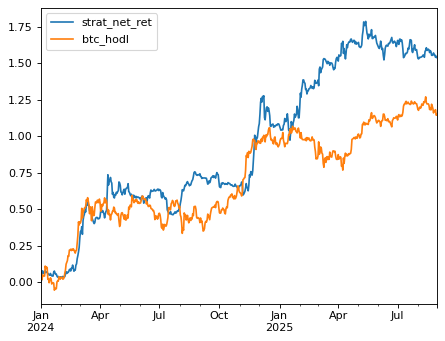

In [28]:
port1, port2, port3 = combined_strat(px_high, px_low, px_close)

prices = px_close

port = eqvol_weights(prices, port1, port2, port3, 90)

ret = prices.ffill().pct_change()

net_ret, gross_ret, turnover = backtest_with_costs(prices[outsample_start:], port[outsample_start:])

print(f"The average turnover is {turnover.mean()}")
print(f"The holding period is {2/turnover.mean()} days")

return_table = pd.DataFrame({
    'strat_gross_ret': calculate_metrics(gross_ret, True),
    'strat_net_ret': calculate_metrics(net_ret, True),
    'btc_hodl': calculate_metrics(ret['BTCUSDT'].loc[outsample_start:]),
})

print(return_table)

overall = pd.DataFrame({
    'strat_net_ret': net_ret,
    'btc_hodl': ret['BTCUSDT'].loc[outsample_start:]
})

overall.cumsum().plot();

In [29]:
overall.cumsum().iloc[-1]

strat_net_ret    1.537826
btc_hodl         1.142456
Name: 2025-08-31 00:00:00, dtype: float64

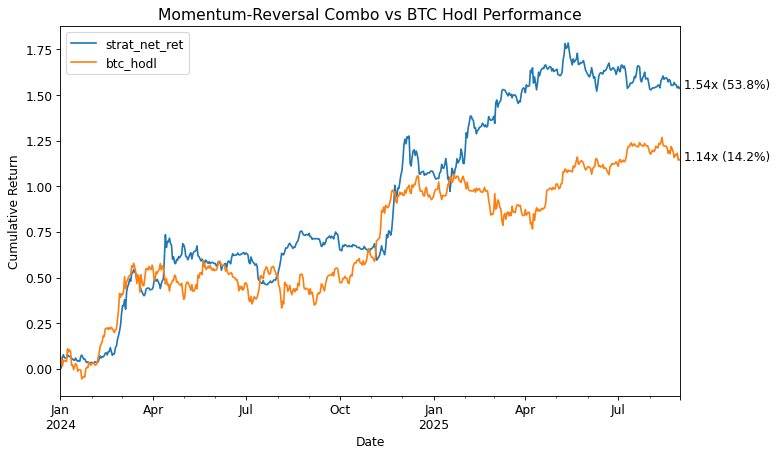

In [30]:
ax = overall.cumsum().plot(title = 'Momentum-Reversal Combo vs BTC Hodl Performance',figsize = (10,6));

ax.set_title("Momentum-Reversal Combo vs BTC Hodl Performance", fontsize=14)
ax.text(x=overall.cumsum().index[-1], y=overall.cumsum().iloc[-1,0], s=' 1.54x (53.8%)', 
        color="black", fontsize=11)
ax.text(x=overall.cumsum().index[-1], y=overall.cumsum().iloc[-1,1], s=' 1.14x (14.2%)', 
        color="black", fontsize=11)
ax.legend(fontsize=11)
ax.set_xlabel('Date', fontsize=11)     # x-axis label
ax.set_ylabel('Cumulative Return', fontsize=11)
ax.tick_params(axis="x", labelsize=11)
ax.tick_params(axis="y", labelsize=11)

plt.show()

In [31]:
consistency_table = pd.DataFrame({
    'strat_ret_2024': calculate_metrics(net_ret.loc['2024']),
    'strat_ret_2025': calculate_metrics(net_ret.loc['2025']),
})

btc_table = pd.DataFrame({
    'btc_hodl_2024': calculate_metrics(ret['BTCUSDT'].loc['2024']),
    'btc_hodl_2025': calculate_metrics(ret['BTCUSDT'].loc['2025']),
})

print('Strategy Yearly Performance:')
print(consistency_table.to_string(), '\n')

print('----------------------------------------------')
print('BTC Buy and Hold Yearly Performance:')
print(btc_table.to_string())

Strategy Yearly Performance:
                      strat_ret_2024 strat_ret_2025
Cumulative Return            162.65%         44.10%
Annualized Return            107.92%         68.45%
Annualized Volatility         48.10%         52.31%
Sharpe Ratio                2.243726       1.308486
Max Drawdown                 -25.71%        -24.47%
Max Drawdown Duration    222.00 days    110.00 days
Win Rate                      51.10%         53.50%
Info Ratio                       N/A            N/A 

----------------------------------------------
BTC Buy and Hold Yearly Performance:
                      btc_hodl_2024 btc_hodl_2025
Cumulative Return           121.31%        15.68%
Annualized Return            93.22%        31.20%
Annualized Volatility        53.08%        43.35%
Sharpe Ratio               1.756296      0.719779
Max Drawdown                -26.15%       -28.10%
Max Drawdown Duration   237.00 days   116.00 days
Win Rate                     52.46%        50.62%
Info Ratio       

In [32]:
btc_hodl_ret = ret.loc[outsample_start:]['BTCUSDT']

In [33]:
net_ret.name = 'strat_net_ret'
btc_hodl_ret.name = 'btc_hodl'
df_rets = pd.concat([net_ret, btc_hodl_ret], axis = 1)

strat_net_ret   -0.282913
btc_hodl        -0.280953
dtype: float64


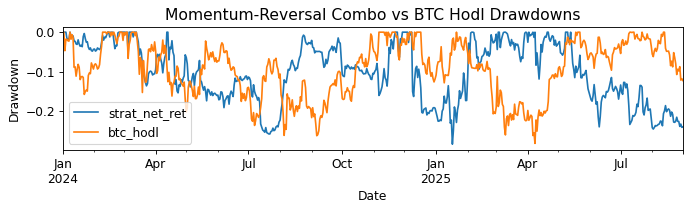

In [34]:
print(drawdown(df_rets).min())
s = drawdown(df_rets)
ax = s.plot( figsize = (10,2), title = "Momentum-Reversal Combo vs BTC Hodl Drawdowns", 
            xlabel = "Date", ylabel = "Drawdown");

ax.set_title("Momentum-Reversal Combo vs BTC Hodl Drawdowns", fontsize=14)
ax.legend(fontsize=11)
ax.set_xlabel('Date', fontsize=11)     # x-axis label
ax.set_ylabel('Drawdown', fontsize=11)
ax.tick_params(axis="x", labelsize=11)
ax.tick_params(axis="y", labelsize=11)

plt.show()

maximum drawdown -28.6%, the strategy maintained shallower drawdowns and faster recovery throughout the years

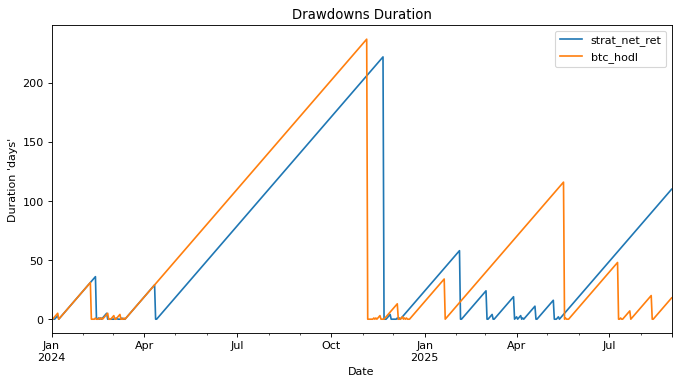

In [35]:
duration(df_rets).plot( figsize = (10,5), title = "Drawdowns Duration", 
                       xlabel = "Date", ylabel = "Duration 'days'");

In [36]:
data = pd.concat([net_ret, btc_hodl_ret], axis=1).dropna()
y = data.iloc[:,0]   # strategy
x = data.iloc[:,1]   # benchmark

#Regression (to get alpha & beta)
X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
alpha_daily, beta = model.params
alpha_ann = alpha_daily * 365  # annualized alpha

# Residual Returns
resid_ret = y - beta * x
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          strat_net_ret   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     17.11
Date:                Tue, 23 Sep 2025   Prob (F-statistic):           4.02e-05
Time:                        10:22:06   Log-Likelihood:                 1366.0
No. Observations:                 609   AIC:                            -2728.
Df Residuals:                     607   BIC:                            -2719.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.716      0.0

In [37]:
print("Alpha (annualized):", alpha_ann)
print("Beta:", beta)

Alpha (annualized): 1.035925293060354
Beta: -0.16684077001285022


- **Alpha (105.1% annualized)**: The strategy consistently generates excess returns independent of market movements.  
- **Beta (-0.17)**: the strategy is almost neutral to BTC, with a small tendency to profit when BTC falls — making it a diversifier and a real alpha generator.

In [38]:
SR = net_ret.mean() / net_ret.std() * np.sqrt(365)
IR = resid_ret.mean() / resid_ret.std() * np.sqrt(365)

print('Strategy Sharpe Ratio is ', SR)
print('Strategy Information Ratio is ', IR)

Strategy Sharpe Ratio is  1.8511605093127197
Strategy Information Ratio is  2.109726517540004


Strategy information ratio is 2.11 which shows consistent and risk efficiency over the benchmark.

At **2.11 IR**, this strategy provides a reliable edge over BTC buy-and-hold

In [39]:
vol = {}
vol['original volatility'] = net_ret.std()*np.sqrt(365)
vol['residual volatility'] = resid_ret.std()*np.sqrt(365)
vol

{'original volatility': 0.4978960561189794,
 'residual volatility': 0.4910234973338009}

In [40]:
print('Strategy return correlation with btc hodl return is ', net_ret.corr(btc_hodl_ret))
print('Strategy residual return correlation with btc hodl return is ', resid_ret.corr(btc_hodl_ret))

Strategy return correlation with btc hodl return is  -0.1655773880859677
Strategy residual return correlation with btc hodl return is  -2.4760616628696473e-16
